In [1]:
%matplotlib inline

This notebook is an effort to replicate the lessons found here:
http://people.ku.edu/~gbohling/cpe940/Variograms.pdf

We'll do all of our imports here at the top.

*Note: This is a work in progress!*

In [2]:
import numpy as np
from pandas import DataFrame, Series
from geostatsmodels import utilities, kriging, variograms, model, geoplot
import matplotlib.pyplot as plt
from scipy.stats import norm
import urllib2 
import os.path
import zipfile
import StringIO

We're going to fetch the data file we need for this exercise from the following URL:

http://people.ku.edu/~gbohling/geostats/WGTutorial.zip

Subsequent runs of this Notebook should use a local copy, saved in the current directory.

In [3]:
clusterfile = 'ZoneA.dat'
if not os.path.isfile(clusterfile):
    fh = urllib2.urlopen('http://people.ku.edu/~gbohling/geostats/WGTutorial.zip')
    data = fh.read()
    fobj = StringIO.StringIO(data)
    myzip = zipfile.ZipFile(fobj,'r')
    myzip.extract(clusterfile)
    fobj.close()
    fh.close()
z = open(clusterfile,'r' ).readlines()
z = [ i.strip().split() for i in z[10:] ]
z = np.array( z, dtype=np.float )
z = DataFrame( z, columns=['x','y','thk','por','perm','lperm','lpermp','lpermr'] )
P = np.array( z[['x','y','por']] )

Let's make a plot of the data, so we know what we're dealing with.

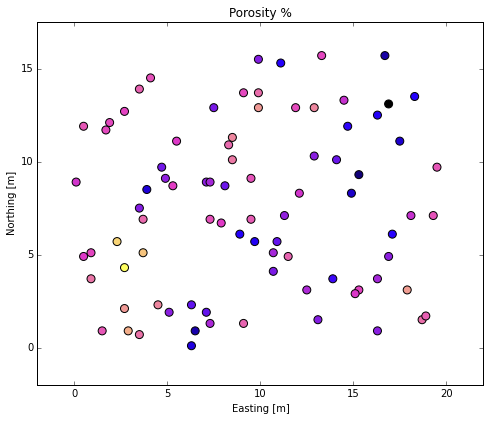

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
cmap = geoplot.YPcmap
ax.scatter( z.x/1000, z.y/1000, c=z.por, s=64,cmap=cmap)
ax.set_aspect(1)
plt.xlim(-2,22)
plt.ylim(-2,17.5)

plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
th=plt.title('Porosity %')

Let's verify that our data is distributed normally.

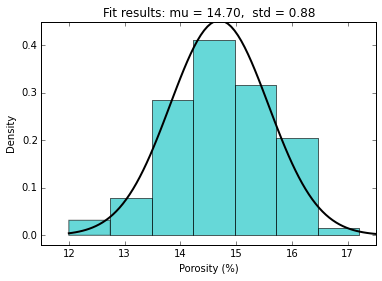

In [15]:
hrange = (12,17.2)
mu, std = norm.fit(z.por)
ahist=plt.hist(z.por, bins=7, normed=True, alpha=0.6, color='c',range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
th=plt.title(title)
xh=plt.xlabel('Porosity (%)')
yh=plt.ylabel('Density')
xl=plt.xlim(11.5,17.5)
yl=plt.ylim(-0.02,0.45)

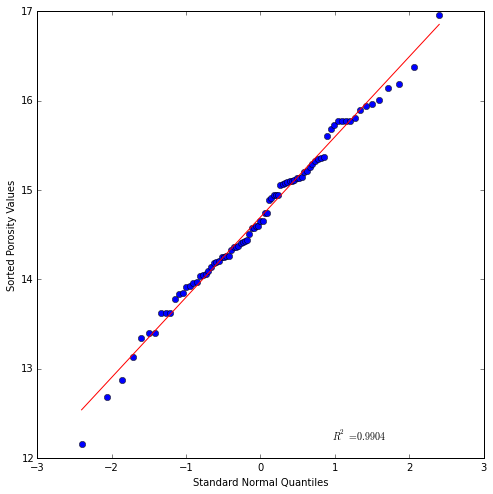

In [16]:
import scipy.stats as stats
qqdata = stats.probplot(z.por, dist="norm",plot=plt,fit=False)
xh=plt.xlabel('Standard Normal Quantiles')
yh=plt.ylabel('Sorted Porosity Values')
fig=plt.gcf()
fig.set_size_inches(8,8)
th=plt.title('')

What is the optimal "lag" distance between points?  Use the utilities scattergram() function to help determine that distance.

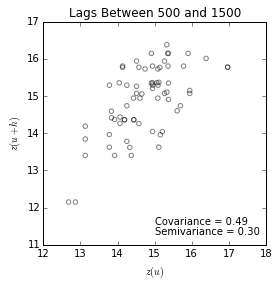

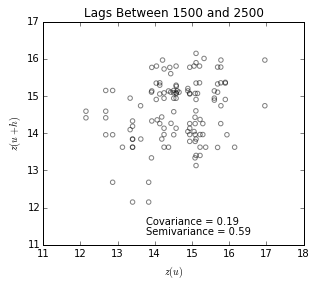

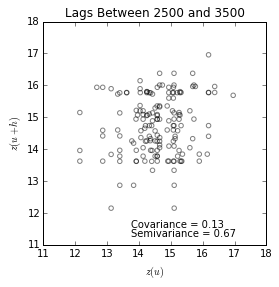

In [7]:
    pw = utilities.pairwise(P)
    geoplot.hscattergram(P,pw,1000,500)
    geoplot.hscattergram(P,pw,2000,500)
    geoplot.hscattergram(P,pw,3000,500)

Here, we plot the semivariogram and overlay a horizontal line for the sill, $c$.

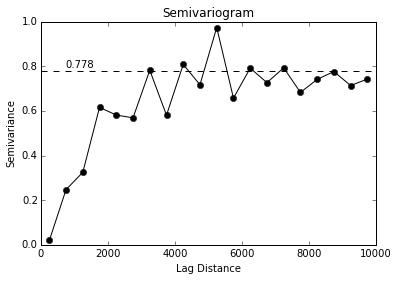

In [8]:
tolerance = 250
lags = np.arange( tolerance, 10000, tolerance*2 )
sill = np.var(P[:,2])

geoplot.semivariogram( P, lags, tolerance )

Looking at the figure above, we can say that the semivariogram levels off around 4000, so we can set the range, $a$, to that value and model the covariance function.

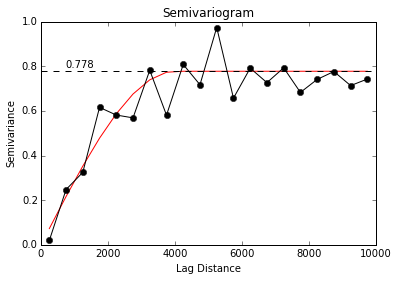

In [9]:
svm = model.semivariance( model.spherical, [ 4000, sill ] )
geoplot.semivariogram( P, lags, tolerance, model=svm )

We can visualize the distribution of the lagged distances with the `laghistogram()` function.

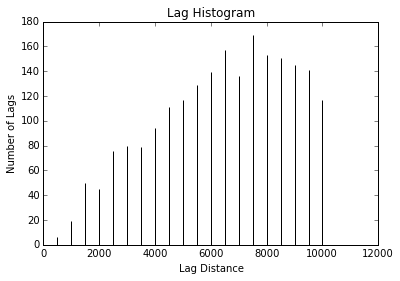

In [10]:
geoplot.laghistogram( P, pw, lags, tolerance )

If we want to perform anisotropic kriging, we can visualize the distribution of the anisotropic lags using the `anisotropiclags()` function. Note that we use the bearing, which is measured in degrees, clockwise from North.

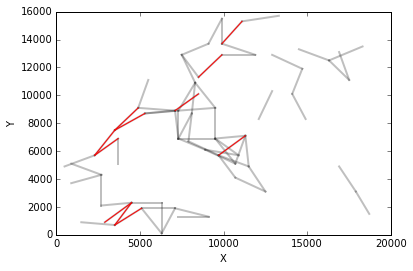

In [11]:
geoplot.anisotropiclags( P, pw, lag=2000, tol=250, angle=45, atol=15 )

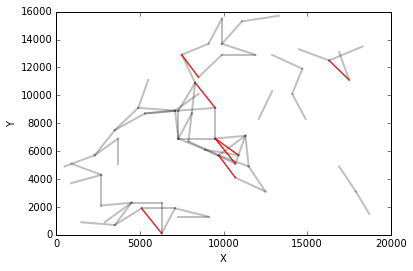

In [12]:
geoplot.anisotropiclags( P, pw, lag=2000, tol=250, angle=135, atol=15 )

/Applications/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


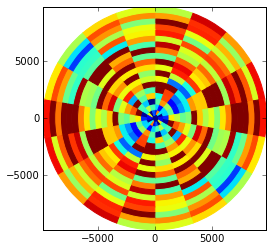

In [13]:
geoplot.polaranisotropy( P, pw, lags, tolerance, nsectors=18 )